In [1]:
# -*- coding: utf-8 -*-
# -*- author : Lokman Mheni - Fabio Palmisano -*-
# -*- date : 2024-04-20 -*-
# -*- Last revision: 2024-06-05 *-
# -*- python version : 3.11.9 -*-
# -*- Description: Logistic Regression with new graph-*-

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from itertools import combinations
from collections import defaultdict
from tqdm import tqdm

#!pip install grakel
from grakel import GraphKernel
from grakel.utils import graph_from_networkx
from tqdm import tqdm

ratings = pd.read_csv('data/ratings.csv')
tr = pd.read_csv( 'data/to_read.csv' )

## Preprocessing of Ratings 

<Axes: >

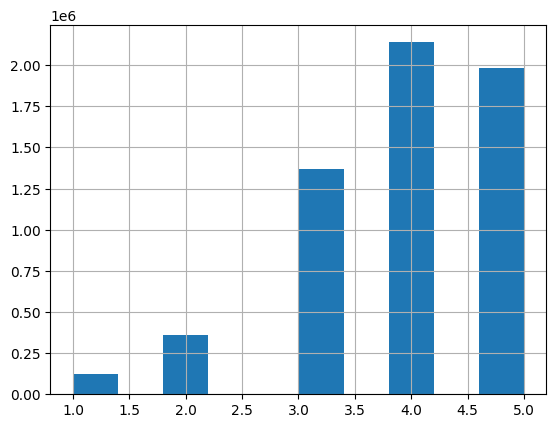

In [3]:
ratings['rating'].hist()

<Axes: >

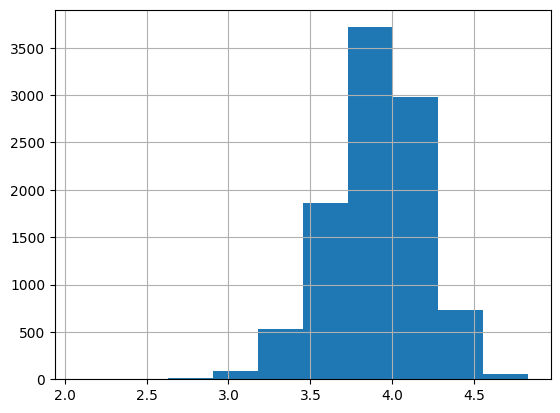

In [4]:
## Can we make the mean ratings per book 
mean_ratings = ratings.groupby('book_id')['rating'].mean()
mean_ratings.hist()

<Axes: xlabel='rating', ylabel='Count'>

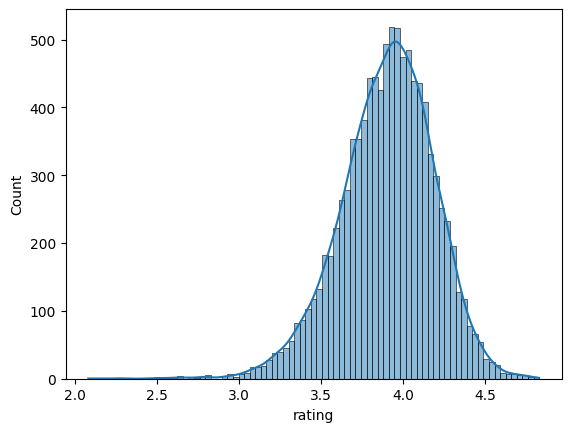

In [5]:
import seaborn as sns
sns.histplot(mean_ratings, kde=True)

In [6]:
mean_ratings

book_id
1        4.279707
2        4.351350
3        3.214341
4        4.329369
5        3.772224
           ...   
9996     4.014184
9997     4.451613
9998     4.323529
9999     3.707692
10000    4.009009
Name: rating, Length: 10000, dtype: float64

<Axes: >

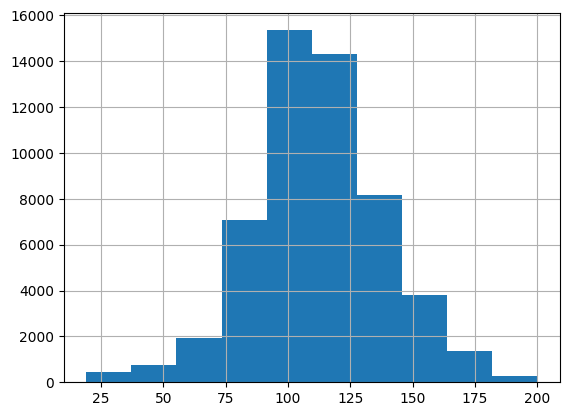

In [7]:
# Can we see the distribution of the number of ratings per user
user_ratings = ratings.groupby('user_id')['rating'].count()
user_ratings.hist()

<Axes: xlabel='rating', ylabel='Count'>

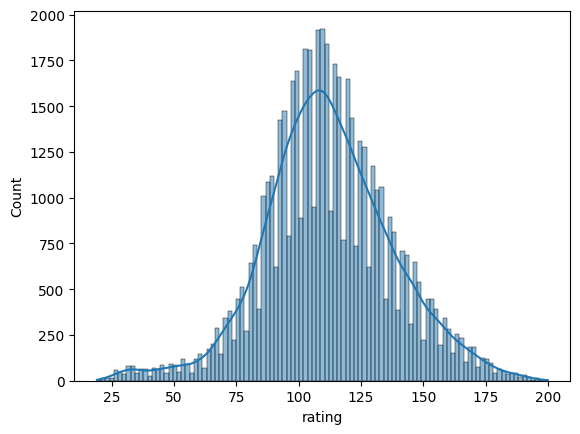

In [8]:
import seaborn as sns
sns.histplot(user_ratings, kde=True)

<Axes: >

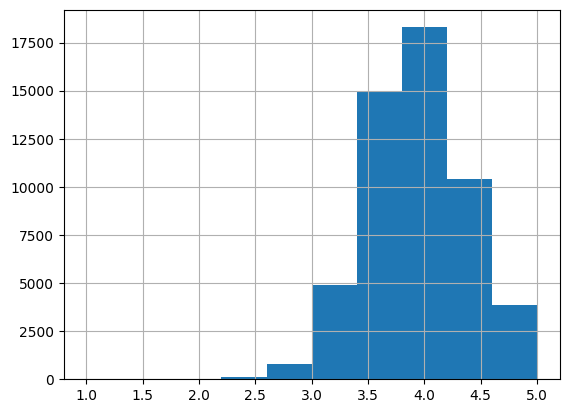

In [9]:
# Can we see the mean ratings distribution per user
mean_user_ratings = ratings.groupby('user_id')['rating'].mean()
mean_user_ratings.hist()


<Axes: xlabel='rating', ylabel='Count'>

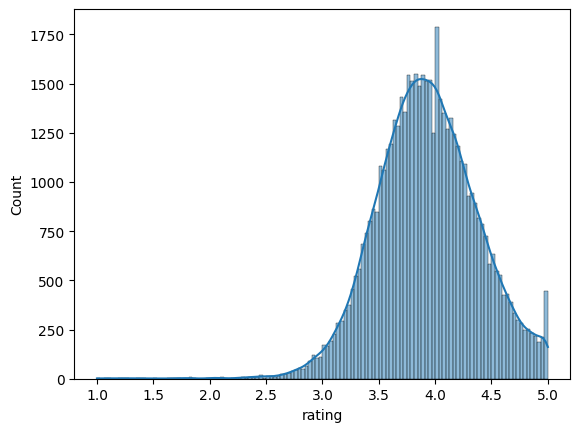

In [10]:
import seaborn as sns
sns.histplot(mean_user_ratings, kde=True)

In [11]:
user_ratings

user_id
1        117
2         65
3         91
4        134
5        100
        ... 
53420    110
53421    110
53422    130
53423     77
53424    133
Name: rating, Length: 53424, dtype: int64

In [12]:
seventyfive_percentile = user_ratings.quantile(0.60)
twentyfive_percentile = user_ratings.quantile(0.40)

In [13]:
seventyfive_percentile, twentyfive_percentile

(117.0, 105.0)

In [14]:
# Oke so now keep only the user that have rated between 25 and 75 percentile (between 96 and 128 books)
user_ratings = user_ratings[(user_ratings >= twentyfive_percentile) & (user_ratings <= seventyfive_percentile)]

In [15]:
user_ratings

user_id
1        117
12       113
14       108
18       109
50       106
        ... 
53398    110
53412    107
53414    116
53420    110
53421    110
Name: rating, Length: 11838, dtype: int64

In [16]:
mean_user_ratings

user_id
1        3.589744
2        4.415385
3        1.736264
4        3.768657
5        4.040000
           ...   
53420    3.345455
53421    4.609091
53422    4.215385
53423    4.454545
53424    4.406015
Name: rating, Length: 53424, dtype: float64

In [17]:
twentyfive_percentile_mean = mean_user_ratings.quantile(0.4)
seventyfive_percentile_mean = mean_user_ratings.quantile(0.6)

twentyfive_percentile_mean, seventyfive_percentile_mean

(3.810810810810811, 4.03030303030303)

In [18]:
# Oke so now keep only the user that have rated between 25 and 75 percentile (between 3.6339 and 4.22321)
mean_user_ratings = mean_user_ratings[(mean_user_ratings >= twentyfive_percentile_mean) & (mean_user_ratings <= seventyfive_percentile_mean)]

mean_user_ratings


user_id
7        3.819355
12       3.867257
17       4.016393
25       4.016667
26       3.990291
           ...   
53394    3.972973
53395    3.914894
53405    3.891892
53408    3.838710
53413    3.908333
Name: rating, Length: 10693, dtype: float64

In [19]:
# Now we can filter and keep only the users that are in both the user_ratings and mean_user_ratings
users = set(user_ratings.index) & set(mean_user_ratings.index)

In [20]:
len(users)

2578

In [21]:
# Oke and now we can keep only the ratings that are in the intersection of the users and books
ratings = ratings[ratings['user_id'].isin(users)]

In [22]:
ratings

,user_id,book_id,rating
822,72,4,5
823,72,55,3
824,72,8,2
825,72,550,5
827,72,1714,5
...,...,...,...
5976135,18147,6753,4
5976136,18147,7892,2
5976322,1670,3371,5
5976323,41342,3175,4


In [23]:
ratings.book_id.nunique()

9823

## Graph Creation (Book to Book based on ratings)


In [24]:
from tqdm import tqdm

# Now we want to create a book to book graph based on the ratings dataset 
# If a book is rated by the same user then we add an edge between the two books
book_to_book = nx.Graph()

# Get a list of unique users
users = ratings['user_id'].unique()

# Loop over users with progress bar
for user in tqdm(users):
    # Get all books rated by this user
    books = ratings[ratings['user_id'] == user]['book_id']
    
    # Loop over all pairs of books
    for book1, book2 in combinations(books, 2):
        if book_to_book.has_edge(book1, book2):
            book_to_book[book1][book2]['weight'] += 1
        else:
            book_to_book.add_edge(book1, book2, weight=1)

  0%|          | 4/2578 [00:00<02:39, 16.14it/s]

100%|██████████| 2578/2578 [00:34<00:00, 75.74it/s]


In [25]:
print(len(book_to_book.nodes()))
print(len(book_to_book.edges()))

9823
6235818


In [34]:
number_to_read =  tr['book_id'].value_counts()
number_to_read = number_to_read.apply(lambda x: 1 if x >= 50 else 0)
number_to_read

book_id
47      1
143     1
113     1
13      1
11      1
       ..
6297    0
7951    0
4434    0
9124    0
8946    0
Name: count, Length: 9986, dtype: int64

In [35]:
number_to_read.value_counts()

count
0    5641
1    4345
Name: count, dtype: int64

In [36]:
nx.set_node_attributes(book_to_book, number_to_read.to_dict(), 'to_read')

In [37]:
book_to_book.nodes[1]

{'to_read': 1}

In [38]:
#check in G_user_books_sample the proportion of nodes set to label 1 (to read) and which are set to 0 (not to read)
to_read = 0
not_to_read = 0
for node in book_to_book.nodes(data=True):
    if node[1].get('to_read', 0) == 1:
        to_read += 1
    else:
        not_to_read += 1
print(to_read, not_to_read)

4334 5489


In [39]:
graph_labels = nx.get_node_attributes(book_to_book, 'to_read')
graph_labels

{4: 1,
 55: 1,
 8: 1,
 550: 1,
 1714: 1,
 118: 1,
 848: 1,
 867: 1,
 10: 1,
 2136: 1,
 230: 1,
 171: 1,
 471: 1,
 64: 1,
 1159: 1,
 2679: 1,
 1060: 1,
 8457: 0,
 408: 1,
 261: 1,
 1313: 1,
 70: 1,
 26: 1,
 89: 1,
 7: 1,
 92: 1,
 211: 1,
 127: 1,
 76: 1,
 344: 1,
 534: 1,
 101: 1,
 4363: 1,
 2128: 1,
 67: 1,
 544: 1,
 681: 1,
 1644: 1,
 1386: 1,
 3293: 1,
 3579: 1,
 4322: 0,
 407: 1,
 3456: 1,
 33: 1,
 37: 1,
 136: 1,
 66: 1,
 123: 1,
 84: 1,
 626: 0,
 620: 1,
 29: 1,
 75: 1,
 148: 1,
 2671: 0,
 42: 1,
 453: 1,
 1457: 0,
 228: 1,
 212: 1,
 496: 1,
 222: 1,
 919: 1,
 2015: 0,
 343: 1,
 15: 1,
 133: 1,
 225: 1,
 58: 1,
 179: 1,
 32: 1,
 119: 1,
 150: 1,
 468: 1,
 22: 1,
 180: 1,
 102: 1,
 59: 1,
 461: 1,
 198: 1,
 271: 1,
 740: 1,
 795: 1,
 38: 1,
 108: 1,
 955: 0,
 1063: 1,
 1436: 0,
 952: 1,
 308: 1,
 411: 1,
 509: 1,
 8384: 0,
 126: 1,
 100: 1,
 398: 1,
 372: 1,
 8627: 0,
 8218: 0,
 98: 1,
 140: 1,
 6: 1,
 137: 1,
 99: 1,
 1: 1,
 1076: 1,
 1396: 1,
 5328: 0,
 24: 1,
 495: 1,
 45: 1,
 5

In [42]:
degree_centrality = nx.degree_centrality(book_to_book)
degree_centrality

{4: 0.9077580940745266,
 55: 0.7405823661168804,
 8: 0.8457544288332315,
 550: 0.3730401140297292,
 1714: 0.23600081449806556,
 118: 0.5749338220321727,
 848: 0.29403380166972104,
 867: 0.2593158216249236,
 10: 0.8424964365709632,
 2136: 0.22123803705966197,
 230: 0.5358379148849521,
 171: 0.594481775605783,
 471: 0.4098961514966402,
 64: 0.6336794950111994,
 1159: 0.22561596416208513,
 2679: 0.1662594176338831,
 1060: 0.2882305029525555,
 8457: 0.06485440847077988,
 408: 0.3811850946854001,
 261: 0.3580737120749338,
 1313: 0.17654245571166768,
 70: 0.7665444919568316,
 26: 0.8434127468947261,
 89: 0.6575035634290368,
 7: 0.8582773365913255,
 92: 0.5327835471390755,
 211: 0.4693545102830381,
 127: 0.492771329668092,
 76: 0.6368356750152718,
 344: 0.4257788637751985,
 534: 0.401038485033598,
 101: 0.5678069639584606,
 4363: 0.17002647118713093,
 2128: 0.21706373447363062,
 67: 0.6589289350437793,
 544: 0.39106088373040115,
 681: 0.39299531663612297,
 1644: 0.21848910608837305,
 1386: 0.

In [41]:
seed = 42
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

## We want for each node take is degree, closeness centrality, betweeness centrality as features and that make a model to predict if it's a blockbuster (1 in to read) or not 
# Create a DataFrame with the degree, closeness centrality, and betweenness centrality of each node
node_features = pd.DataFrame(index=book_to_book.nodes())
print("Node features1: ", node_features)
# Calculate the degree of each node
node_features['degree'] = pd.Series(dict(book_to_book.degree()))
print("Node features2: ", node_features)
# Calculate the degree centrality of each node
node_features['degree_centrality'] = pd.Series(nx.degree_centrality(book_to_book))
print("Node features3: ", node_features)
# Calculate the closeness centrality of each node
node_features['closeness'] = pd.Series(nx.closeness_centrality(book_to_book))
print("Node features4: ", node_features)
# Calculate the betweenness centrality of each node
node_features['betweenness'] = pd.Series(nx.betweenness_centrality(book_to_book))
print("Node features5: ", node_features)
#Calculate the clustering coefficient of each node
node_features['clustering'] = pd.Series(nx.clustering(book_to_book))
print("Node features6: ", node_features)
# Calculate the eigenvector centrality of each node
node_features['eigenvector'] = pd.Series(nx.eigenvector_centrality(book_to_book))
print("Node features7: ", node_features)
# Calculate the pagerank of each node
node_features['pagerank'] = pd.Series(nx.pagerank(book_to_book))
print("Node features8: ", node_features)
# Calculate the average neighbor degree of each node
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(book_to_book))
print("Node features9: ", node_features)
# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)
print("Node features10: ", node_features)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)
print("Node features11: ", node_features)
# Train a simple model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

Node features1:  Empty DataFrame
Columns: []
Index: [4, 55, 8, 550, 1714, 118, 848, 867, 10, 2136, 230, 171, 471, 64, 1159, 2679, 1060, 8457, 408, 261, 1313, 70, 26, 89, 7, 92, 211, 127, 76, 344, 534, 101, 4363, 2128, 67, 544, 681, 1644, 1386, 3293, 3579, 4322, 407, 3456, 33, 37, 136, 66, 123, 84, 626, 620, 29, 75, 148, 2671, 42, 453, 1457, 228, 212, 496, 222, 919, 2015, 343, 15, 133, 225, 58, 179, 32, 119, 150, 468, 22, 180, 102, 59, 461, 198, 271, 740, 795, 38, 108, 955, 1063, 1436, 952, 308, 411, 509, 8384, 126, 100, 398, 372, 8627, 8218, ...]

[9823 rows x 0 columns]
Node features2:        degree
4       8916
55      7274
8       8307
550     3664
1714    2318
...      ...
6075     104
9971     104
9548     104
9535     104
9015     104

[9823 rows x 1 columns]
Node features3:        degree  degree_centrality
4       8916           0.907758
55      7274           0.740582
8       8307           0.845754
550     3664           0.373040
1714    2318           0.236001
...      ...   

KeyboardInterrupt: 

In [55]:
seed = 42
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

## We want for each node take is degree, closeness centrality, betweeness centrality as features and that make a model to predict if it's a blockbuster (1 in to read) or not 
# Create a DataFrame with the degree, closeness centrality, and betweenness centrality of each node
node_features = pd.DataFrame(index=book_to_book.nodes())
print("Node features1: ", node_features)
# Calculate the degree of each node
node_features['degree'] = pd.Series(dict(book_to_book.degree()))
print("Node features2: ", node_features)
# Calculate the degree centrality of each node
node_features['degree_centrality'] = pd.Series(nx.degree_centrality(book_to_book))
print("Node features3: ", node_features)
# Calculate the eigenvector centrality of each node
node_features['eigenvector_centrality'] = pd.Series(nx.eigenvector_centrality(book_to_book))
print("Node features4: ", node_features)
# Calculate the PageRank of each node
node_features['pagerank'] = pd.Series(nx.pagerank(book_to_book))
print("Node features8: ", node_features)
# Calculate the average neighbor degree of each node
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(book_to_book))
print("Node features9: ", node_features)
# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)
print("Node features10: ", node_features)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)
print("Node features11: ", node_features)
# Train a simple model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

Node features1:  Empty DataFrame
Columns: []
Index: [4, 55, 8, 550, 1714, 118, 848, 867, 10, 2136, 230, 171, 471, 64, 1159, 2679, 1060, 8457, 408, 261, 1313, 70, 26, 89, 7, 92, 211, 127, 76, 344, 534, 101, 4363, 2128, 67, 544, 681, 1644, 1386, 3293, 3579, 4322, 407, 3456, 33, 37, 136, 66, 123, 84, 626, 620, 29, 75, 148, 2671, 42, 453, 1457, 228, 212, 496, 222, 919, 2015, 343, 15, 133, 225, 58, 179, 32, 119, 150, 468, 22, 180, 102, 59, 461, 198, 271, 740, 795, 38, 108, 955, 1063, 1436, 952, 308, 411, 509, 8384, 126, 100, 398, 372, 8627, 8218, ...]

[9823 rows x 0 columns]
Node features2:        degree
4       8916
55      7274
8       8307
550     3664
1714    2318
...      ...
6075     104
9971     104
9548     104
9535     104
9015     104

[9823 rows x 1 columns]
Node features3:        degree  degree_centrality
4       8916           0.907758
55      7274           0.740582
8       8307           0.845754
550     3664           0.373040
1714    2318           0.236001
...      ...   

,Real,Predicted
2290,1,1
2683,0,1
7710,0,0
19,1,1
8557,0,0
...,...,...
5954,1,0
2437,1,1
9896,1,0
9200,0,0


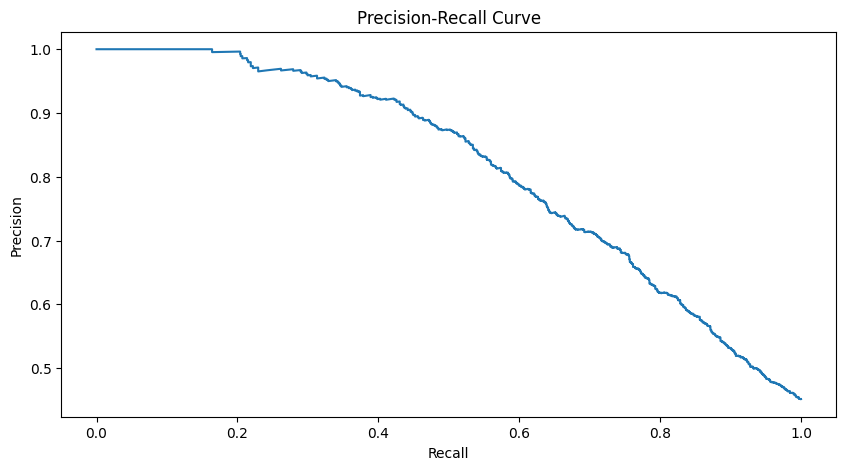

In [56]:
from sklearn.metrics import precision_recall_curve

# Get the probabilities of the positive class
y_scores = model.predict_proba(X_test)[:, 1]

# Get the precision and recall values for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find the threshold that gives the best F1 score
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]

# Use this threshold to predict the classes
y_pred = (y_scores > best_threshold).astype(int)

# Print the precision-recall curve for the model 
plt.figure(figsize=(10, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

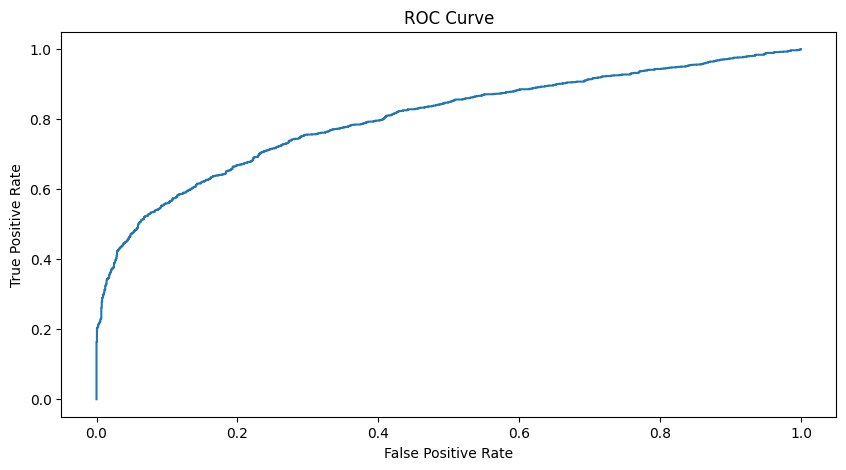

In [57]:
# Plot the ROC curve
from sklearn.metrics import roc_curve

# Get the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot the ROC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

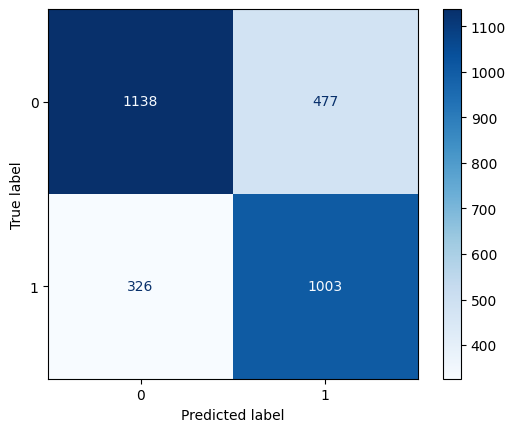

In [58]:
# Plot the matrix of confusion
from sklearn.metrics import ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()


In [ ]:
seed = 42
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

## We want for each node take is degree, closeness centrality, betweeness centrality as features and that make a model to predict if it's a blockbuster (1 in to read) or not 
# Create a DataFrame with the degree, closeness centrality, and betweenness centrality of each node
node_features = pd.DataFrame(index=book_to_book.nodes())
print("Node features1: ", node_features)
# Calculate the degree of each node
node_features['degree'] = pd.Series(dict(book_to_book.degree()))
print("Node features2: ", node_features)
# Calculate the degree centrality of each node
node_features['degree_centrality'] = pd.Series(nx.degree_centrality(book_to_book))
print("Node features3: ", node_features)
# Calculate the closeness centrality of each node
node_features['closeness'] = pd.Series(nx.closeness_centrality(book_to_book))
print("Node features4: ", node_features)
# Calculate the betweenness centrality of each node
node_features['betweenness'] = pd.Series(nx.betweenness_centrality(book_to_book))
print("Node features5: ", node_features)
#Calculate the clustering coefficient of each node
node_features['clustering'] = pd.Series(nx.clustering(book_to_book))
print("Node features6: ", node_features)
# Calculate the eigenvector centrality of each node
node_features['eigenvector'] = pd.Series(nx.eigenvector_centrality(book_to_book))
print("Node features7: ", node_features)
# Calculate the pagerank of each node
node_features['pagerank'] = pd.Series(nx.pagerank(book_to_book))
print("Node features8: ", node_features)
# Calculate the average neighbor degree of each node
node_features['average_neighbor_degree'] = pd.Series(nx.average_neighbor_degree(book_to_book))
print("Node features9: ", node_features)
# Merge the node features with the graph labels
node_features = node_features.merge(pd.Series(graph_labels, name ='graph_labels'), left_index=True, right_index=True)
print("Node features10: ", node_features)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(node_features.drop('graph_labels', axis=1), node_features['graph_labels'], test_size=0.3, random_state=seed)
print("Node features11: ", node_features)
# Train a simple model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

print(y_pred)
# Calculate the accuracy of the model
accuracy_score(y_test, y_pred)

#F1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


# Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

pd.DataFrame({'Real': y_test, 'Predicted': y_pred})

## Try with Neural Network Now

Epoch 1, Loss: 56.19670542339946
Epoch 2, Loss: 56.25968991656636
Epoch 3, Loss: 56.19670542339946
Epoch 4, Loss: 56.25968991656636
Epoch 5, Loss: 56.19670542339946
Epoch 6, Loss: 56.19670542339946
Epoch 7, Loss: 56.133720930232556
Epoch 8, Loss: 56.133720930232556
Epoch 9, Loss: 56.32267441860465
Epoch 10, Loss: 56.19670542339946


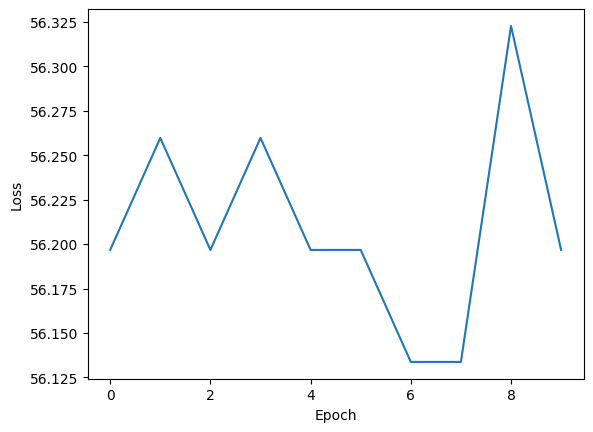

Accuracy: 45.14
F1 Score: 0.62


In [60]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)

# Create a DataLoader for the training data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

# Define the model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize a list to store the losses for each epoch
losses = []

# Train the model
for epoch in range(10):
    epoch_losses = []
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Save the loss for this batch
        epoch_losses.append(loss.item())

    # Save the average loss for this epoch
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')

# Plot the losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

Epoch 1, Loss: 0.7263138627590136
Epoch 2, Loss: 0.5682024751638257
Epoch 3, Loss: 0.5439946368856485
Epoch 4, Loss: 0.5400008013082105
Epoch 5, Loss: 0.539624337401501
Epoch 6, Loss: 0.5366508503292882
Epoch 7, Loss: 0.5384295157914938
Epoch 8, Loss: 0.5369156470478967
Epoch 9, Loss: 0.5384308134400567
Epoch 10, Loss: 0.5361255715406218
Epoch 11, Loss: 0.5364024894182072
Epoch 12, Loss: 0.5378613494163336
Epoch 13, Loss: 0.538464498381282
Epoch 14, Loss: 0.5372797228569208
Epoch 15, Loss: 0.5366494649717974
Epoch 16, Loss: 0.535679297738297
Epoch 17, Loss: 0.5359105947405793
Epoch 18, Loss: 0.5332606813935347
Epoch 19, Loss: 0.534850246892419
Epoch 20, Loss: 0.5348740678887035
Epoch 21, Loss: 0.5325686184472815
Epoch 22, Loss: 0.5353242269089056
Epoch 23, Loss: 0.5351981919865275
Epoch 24, Loss: 0.5347613889810651
Epoch 25, Loss: 0.5317203982971436
Epoch 26, Loss: 0.533758497272813
Epoch 27, Loss: 0.5341666746971219
Epoch 28, Loss: 0.5326898603245269
Epoch 29, Loss: 0.5319099356961805

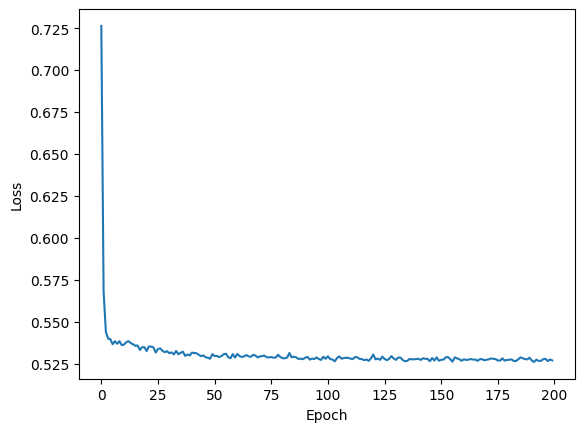

Accuracy: 74.83
F1 Score: 0.67


In [85]:
# Define a more complex model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize a list to store the losses for each epoch
losses = []

# Train the model
for epoch in range(500):  # Increase the number of epochs
    epoch_losses = []
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Save the loss for this batch
        epoch_losses.append(loss.item())

    # Save the average loss for this epoch
    losses.append(sum(epoch_losses) / len(epoch_losses))
    print(f'Epoch {epoch+1}, Loss: {losses[-1]}')

# Plot the losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs.squeeze() > 0.5).float()
    accuracy = (predicted == y_test_tensor).float().mean()
    print('Accuracy: %.2f' % (accuracy*100))

# Calculate and print the F1 score
f1 = f1_score(y_test_tensor, predicted)
print('F1 Score: %.2f' % f1)

In [83]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = torch.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return torch.log_softmax(x, dim=1)

# Assume edge_index is a torch tensor of size [2, num_edges] and x is a torch tensor of size [num_nodes, num_features]
# edge_index[0] and edge_index[1] represent the start and end nodes of edges respectively
# x[i] represents the features of the i-th node
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)

# Get the list of edges
edges = list(book_to_book.edges())

# Create a mapping from the original node indices to the new ones
node_mapping = {node: i for i, node in enumerate(book_to_book.nodes())}

# Remap the edges
edges_remap = [(node_mapping[u], node_mapping[v]) for u, v in edges]

# Create the edge_index tensor
edge_index = torch.tensor(edges_remap, dtype=torch.long).t().contiguous()

# Create the Data object
data = Data(x=X_train_tensor, edge_index=edge_index)

# Initialize the model and the optimizer
model = GCN(num_features=X_train_tensor.size(1), num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Test the model
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

TypeError: unsupported operand type(s) for -: 'NodeView' and 'int'